# Example: MNIST Data Set -  Convolution Model

This is an extension of the [Notebook 1 Tutotial](https://github.com/clonker/bms-summerschool19-tf/blob/master/bms-tensorflow-tutorial-1.ipynb).

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

## Load + Prepare Data

Let us prepare the data as in the [previous](https://github.com/juanitorduz/math_deep_learning_summer_school19/blob/master/keras/mnist_sequential.ipynb) notebook.

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)

Let us see the shape of the training data:

In [3]:
x_train.shape

(60000, 28, 28)

Note that the first dimension contains the number of observations. 

We can send this dimension to the end by transposing it:

In [4]:
x_train_t =np.transpose(a=x_train, axes=(1,2,0))
x_train_t.shape

(28, 28, 60000)

Let us verify thatt this works as expected:

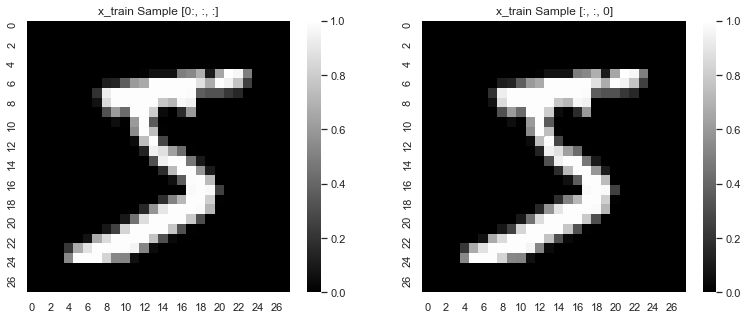

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 5))

sns.heatmap(data=x_train[0, :, :], cmap='gist_gray', ax=ax1)
ax1.set(title='x_train Sample [0:, :, :]');
sns.heatmap(data=x_train_t[:, :, 0], cmap='gist_gray', ax=ax2)
ax2.set(title='x_train Sample [:, :, 0]');

- Datasets

Now we want to encode the data as a [Dataset](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset). From the documentation: *A **Dataset** can be used to represent an input pipeline as a collection of elements (nested structures of tensors) and a "logical plan" of transformations that act on those elements.*

In [6]:
# Construct the dataset from numpy arrays.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

Let us the what this object is:

In [7]:
train_dataset

<TensorSliceDataset shapes: ((28, 28), ()), types: (tf.float32, tf.uint8)>

In [8]:
# We can get a generator:
train_dataset.__iter__()

In [9]:
# We can use `next` to accest the first element. 
# Let us evaluate its type and sie
print(type(next(train_dataset.__iter__())))
print(len(next(train_dataset.__iter__())))

<class 'tuple'>
2


This 2-length tuple has the image array in the first component and the label in the second component:

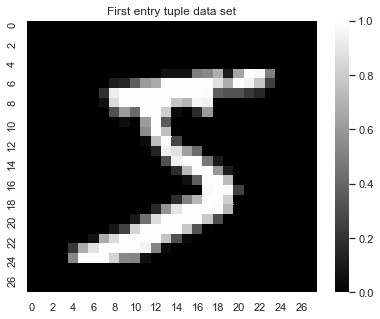

In [10]:
fig, ax = plt.subplots(figsize=(6.5, 5))

sns.heatmap(next(train_dataset.__iter__())[0], cmap='gist_gray', ax=ax)
ax.set(title='First entry tuple data set');

In [11]:
next(train_dataset.__iter__())[1]

<tf.Tensor: id=39, shape=(), dtype=uint8, numpy=5>

Let us now add a `channel` dimension:

In [12]:
train_dataset = train_dataset.map(lambda x, y: (tf.expand_dims(x, -1), y))
test_dataset= test_dataset.map(lambda x, y: (tf.expand_dims(x, -1), y))

In [13]:
train_dataset

<MapDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.uint8)>

Note that we have a new dimesnion added. This can be also done using `np.newaxis` for numpy arrays.

In [14]:
# which on direct numpy data would be
x_train2 = x_train[..., np.newaxis]
x_test2 = x_test[..., np.newaxis]

In [15]:
x_train2.shape

(60000, 28, 28, 1)

Let us finally tansform to batch data:

In [16]:
# Batch data.
batch_size = 256
train_dataset = train_dataset.shuffle(len(x_train)).batch(batch_size)
test_dataset= test_dataset.batch(batch_size)

In [17]:
train_dataset

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.uint8)>

The new dimension refered as `None` represents the batch dimension. Let us verify the first entry of the generator has the batch size:

In [18]:
len(next(train_dataset.__iter__())[0])

256

## Define Model

In [19]:
model = tf.keras.models.Sequential([
    # Convolution Layer. 
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    # Flatten output. 
    tf.keras.layers.Flatten(),
    # Dense Layer. 
    tf.keras.layers.Dense(units=128, activation='relu'),
    # Output Layer.
    tf.keras.layers.Dense(units=10, activation='softmax')
])

# we compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2769024   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
_________________________________________________________________


Recall that the output dimension of a convolutional layer is $n_{i} - n_{f} - 1$, where $n_i$ and $n_f$ denote the input dimension and the filter size respectively. In this case:

In [20]:
28 - 3 + 1

26

When we flatten the data we obtain the dimension (see model summary above)

In [21]:
26 * 26 * 32

21632

Let us see the prediction for the first image with the initial random weights.

In [22]:
classes = np.unique(y_train)
classes 

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

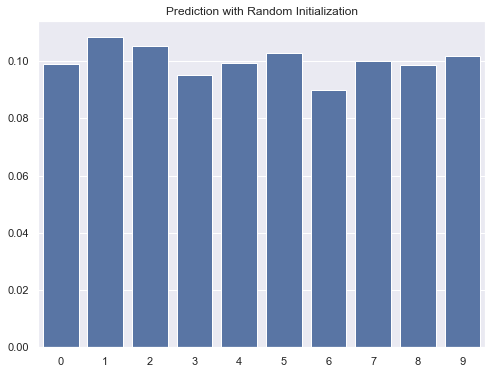

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

image, label = next(train_dataset.__iter__())
prediction = model.apply(image[0:1])

sns.barplot(x=classes , y=prediction[0], color='b', ax=ax)
ax.set(title='Prediction with Random Initialization');

## Train Model 

In [24]:
model_history = model.fit(
    train_dataset,
    epochs=15, 
    validation_data=(x_test2, y_test)
)

Epoch 1/15


W0826 15:44:35.656977 4670666176 deprecation.py:323] From /Users/juanitorduz/anaconda3/envs/bms_summer19/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


235/235 [==============================] - 9s 38ms/step - loss: 0.2330 - accuracy: 0.9336 - val_loss: 0.0859 - val_accuracy: 0.9730
Epoch 2/15
235/235 [==============================] - 9s 38ms/step - loss: 0.0644 - accuracy: 0.9819 - val_loss: 0.0587 - val_accuracy: 0.9817
Epoch 3/15
235/235 [==============================] - 9s 37ms/step - loss: 0.0384 - accuracy: 0.9895 - val_loss: 0.0543 - val_accuracy: 0.9811
Epoch 4/15
235/235 [==============================] - 9s 39ms/step - loss: 0.0243 - accuracy: 0.9938 - val_loss: 0.0607 - val_accuracy: 0.9807
Epoch 5/15
235/235 [==============================] - 9s 37ms/step - loss: 0.0165 - accuracy: 0.9961 - val_loss: 0.0574 - val_accuracy: 0.9824
Epoch 6/15
235/235 [==============================] - 9s 37ms/step - loss: 0.0123 - accuracy: 0.9969 - val_loss: 0.0571 - val_accuracy: 0.9830
Epoch 7/15
235/235 [==============================] - 9s 38ms/step - loss: 0.0098 - accuracy: 0.9976 - val_loss: 0.0564 - val_accuracy: 0.9841
Epoch 8/15

## Model Evaluation

In [25]:
# Store history in a data frame. 
hist_df = pd.DataFrame(model_history.history)
hist_df['epoch'] = model_history.epoch

hist_df.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.233409,0.933617,0.085931,0.9730,0
1,0.064507,0.981900,0.058665,0.9817,1
2,0.038514,0.989467,0.054331,0.9811,2
3,0.024297,0.993767,0.060708,0.9807,3
4,0.016562,0.996050,0.057407,0.9824,4


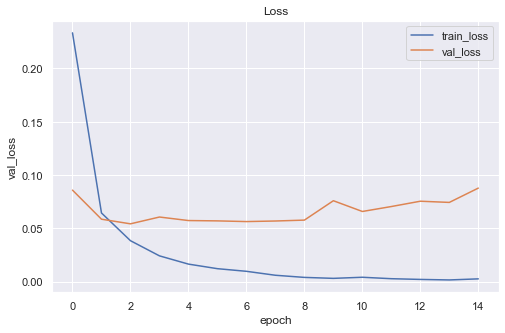

In [26]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(x='epoch', y='loss', data=hist_df, ax=ax, label='train_loss')
sns.lineplot(x='epoch', y='val_loss', data=hist_df, ax=ax, label='val_loss')
ax.set(title='Loss')
ax.legend(loc='upper right');

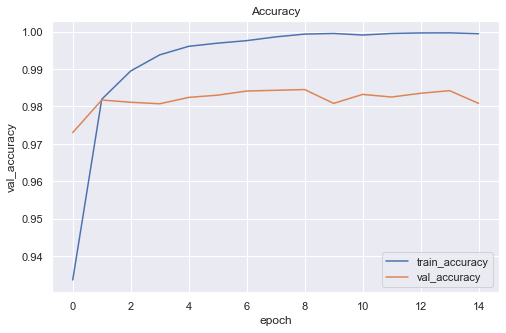

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(x='epoch', y='accuracy', data=hist_df, ax=ax, label='train_accuracy')
sns.lineplot(x='epoch', y='val_accuracy', data=hist_df, ax=ax, label='val_accuracy')
ax.set(title='Accuracy')
ax.legend(loc='lower right');

In [28]:
model.evaluate(x_test2, y_test)

10000/10000 [==============================] - 1s 67us/sample - loss: 0.0885 - accuracy: 0.9808


[0.0885416270219248, 0.9808]

In [29]:
y_pred = model.apply(x_test2)

In [30]:
y_pred_classes = tf.argmax(y_pred, axis=1)

Let us see where the model did not predcut the right class:

In [31]:
pred_diff = y_test - y_pred_classes.numpy()

In [32]:
indices = np.where(np.not_equal(pred_diff, 0))
indices = indices[0]

In [33]:
def get_miss_prediction(y_test, x_test, y_pred_classes, indices, i):
    
    true_label = y_test[indices[i]]
    
    pred_label = y_pred_classes.numpy()[indices[i]]
    
    y_pred_classes.numpy()[indices[i]]
    
    fig, ax = plt.subplots(figsize=(8, 6))

    sns.heatmap(data=x_test[indices[i]], cmap='gist_gray', ax=ax)
    ax.set(title=f'True Label = {true_label} & Pred Label = {pred_label}');

### Examples

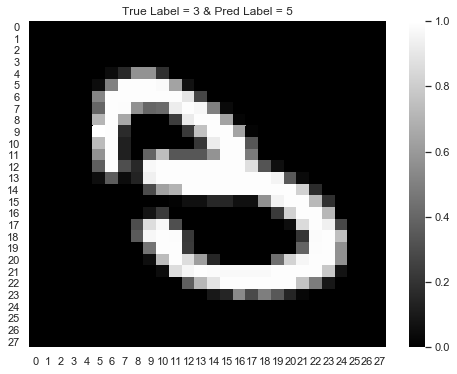

In [34]:
get_miss_prediction(y_test, x_test, y_pred_classes, indices, 0)

- Example 2

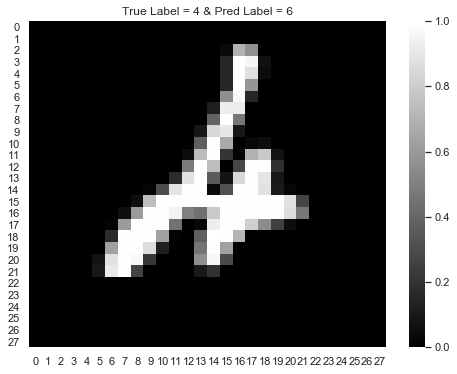

In [35]:
get_miss_prediction(y_test, x_test, y_pred_classes, indices, 3)

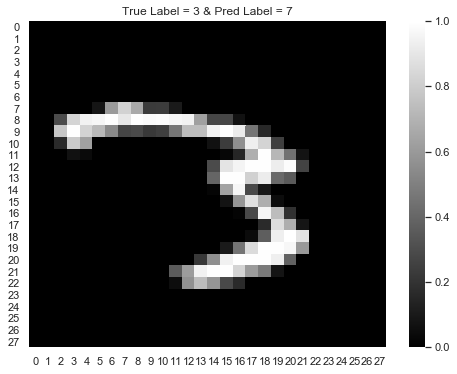

In [36]:
get_miss_prediction(y_test, x_test, y_pred_classes, indices, 5)